# Diffusion Generative Models and Inpainting Techniques

This notebook serves as a general introduction to the topic of diffusion models and their application to the problem of inpainting. It begins with a description of the theoretical foundations of diffusion models with a focus on intuitions that help in grasping the topic from a practical point of view. Then, one of the most popular formulations of diffusion models is introduced together with its extension to controllable generation. At last, image inpainting is defined as a specific instance of controllable generation and one of the first algorithms that utilizes diffusion models in solving it is described.

### Bibliography

[1] Song et al., _Score-Based Generative Modeling Through Stochastic Differential Equations_, ICLR 2021  
[2] Brian D O Anderson, _Reverse-time diffusion equation models. Stochastic Processes and their Applications_, 1982  
[3] Ronneberger et al., _U-Net: Convolutional Networks for Biomedical Image Segmentation_, MICCAI 2015  
[4] Karras et al., _Progressive Growing of GANs for Improved Quality, Stability, and Variation_, ICLR, 2018  
[5] Chung et al., _Improving Diffusion Models for Inverse Problems using Manifold Constraints_, NeurIPS, 2022  
[6] Lugmayr et al., _RePaint: Inpainting using Denoising Diffusion Probabilistic Models_, CVPR, 2022  
[7] Chung et al, _Diffusion Posterior Sampling for General Noisy Inverse Problems_, ICLR, 2023  

## Introduction to diffusion models

### Stochastic differential equations

One of the most popular and general formulations of diffusion models is based on stochastic differential equations (SDEs) and was first introduced in the paper by Song et al. [[1]](#bibliography).

SDEs are a generalization of ordinary differential equations (ODEs) to dynamical systems characterized by some form of stochasticity. They are often mentioned in the context of thermodynamics, stock prices prediction or more generally in any domain which involves modelling some form of randomness in a complex system.


Let us denote by $\mathbf{x}(t)$ the state of some system at time $t$ and assume that $\mathbf{x}(0) = \mathbf{x}_0$, i.e. the state of this system at time $t=0$ is equal to $\mathbf{x}_0$. SDEs model the behaviour of this system with the following equation:

\begin{equation}
\frac{d \mathbf{x}(t)}{d t} = \mathbf{f}(\mathbf{x}(t), t) + g(t) \frac{d \mathbf{w}}{d t}, \tag{1}
\end{equation}

where $\mathbf{w}$ is the standard Wiener process (also called the Brownian motion), $\mathbf{f}(\cdot, t): \mathbb{R}^d \rightarrow \mathbb{R}^d$ is a vector-valued function called the _drift_ coefficient of $\mathbf{x}(t)$, and $g(\cdot): \mathbb{R} \rightarrow \mathbb{R}$ is a scalar function known as the _diffusion_ coefficient of $\mathbf{x}(t)$.

Importantly, the randomness induced by the Brownian motion compels us to think about the system at some specific time $t$ in a probabilistic manner. Hence, instead of a specific state, we think about the probability distribution over all possible states at time $t$, which density we denote by $p_t(\mathbf{x}(t))$.

To obtain a more intuitive understanding of how the probability distribution of solutions to some example of the above SDE evolves over time, one can plot their corresponding probability density functions in a simple case, where the system starts from a mixture of two gaussian distributions and diffuses into a single Gaussian distribution through time. The plot below visualizes the case in which we assume that the initial distribution is a mixture of equally weighted gaussians $\mathcal{N}(\pm 2, 0.5)$, the final distribution is also a gaussian $\mathcal{N}(0, 2)$ and the transition happens linearly. This corresponds to picking 

$$ \mathbf{f}(\mathbf{x}(t), t)= - \mathbf{x}(t), $$
$$ g(t)=\sqrt{(1 - \alpha(t)) \cdot 0.5 + \alpha(t) \cdot 2}, $$ 

where $\alpha(t)=t$ and $t$ spans the range $[0, 1]$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import Normalize

# Parameters for the initial mixture of 2D Gaussians
mean1, cov1 = [-2, -2], [[0.5, 0], [0, 0.5]]
mean2, cov2 = [2, 2], [[0.5, 0], [0, 0.5]]
weight1, weight2 = 0.5, 0.5

# Parameters for the target 2D standard Gaussian
target_mean, target_cov = [0, 0], [[2, 0], [0, 2]]

# Define the grid for plotting
x, y = np.mgrid[-5:5:0.1, -5:5:0.1]
pos = np.dstack((x, y))

# Function to compute the PDF of the initial mixture of 2D Gaussians
def mixture_pdf(pos):
    rv1 = multivariate_normal(mean1, cov1)
    rv2 = multivariate_normal(mean2, cov2)
    return weight1 * rv1.pdf(pos) + weight2 * rv2.pdf(pos)

# Function to compute the PDF of the target 2D standard Gaussian
def target_pdf(pos):
    rv = multivariate_normal(target_mean, target_cov)
    return rv.pdf(pos)

# Function to compute the intermediate PDF
def intermediate_pdf(pos, alpha):
    return (1 - alpha) * mixture_pdf(pos) + alpha * target_pdf(pos)

# Generate the PDFs for intermediate steps
alphas = np.linspace(0, 1, 10000)
pdf_values = np.array([intermediate_pdf(pos, alpha) for alpha in alphas])

# Plot the evolution of the PDFs
plt.figure(figsize=(15, 5))

# Create a large grid to plot all intermediate steps side by side
evolution_grid = np.zeros((x.shape[0], x.shape[1] * len(alphas)))

for i in range(len(alphas)):
    evolution_grid[:, i * x.shape[1]:(i + 1) * x.shape[1]] = pdf_values[i]

class CustomNorm(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Apply custom normalization logic
        normalized_value = value ** (1/2)  # Example: square root normalization
        return super().__call__(normalized_value, clip)

<Figure size 1500x500 with 0 Axes>

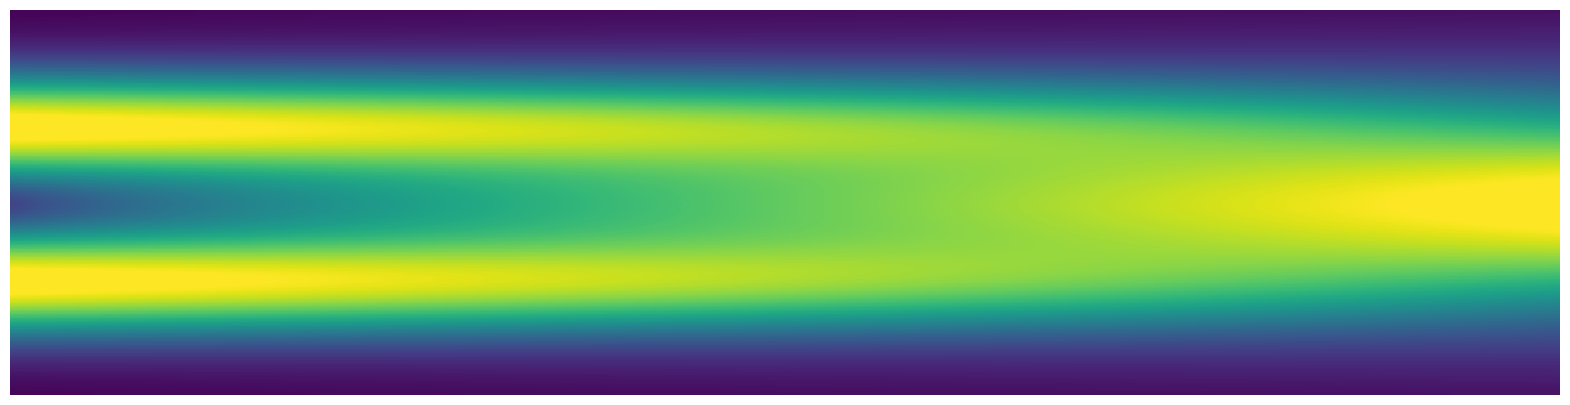

In [2]:
plt.figure(figsize=(20, 5))
plt.imshow(evolution_grid, extent=[0, len(alphas), -5, 5], aspect='auto', cmap='viridis', norm=CustomNorm())
plt.axis('off')
plt.show()

It is also possible to overlay the evolution of densities with individual trajectories that result from following the dynamics defined by the SDE with the mentioned parameters. The plot below shows two example trajectories starting from the centers of respective gaussians.

In [3]:
def example_sde(ts = np.linspace(0, 1, 10000), x_0 = 2):
    
    drift_coef = lambda x: - x
    alpha_coef = lambda t: t
    x = x_0
    xs = [x]

    for t_next, t_current in zip(ts[1:], ts[:-1]):
        dt = (t_next - t_current)
        diff_coef = ((1 - alpha_coef(t_current)) * 0.5 + alpha_coef(t_current) * 2) ** (1 / 2)
        eps = np.random.randn() * (dt ** (1 / 2))
        x += drift_coef(x) * dt + diff_coef * eps
        xs.append(x.item())

    return xs

traj_1 = example_sde()
traj_2 = example_sde(x_0 = -2)

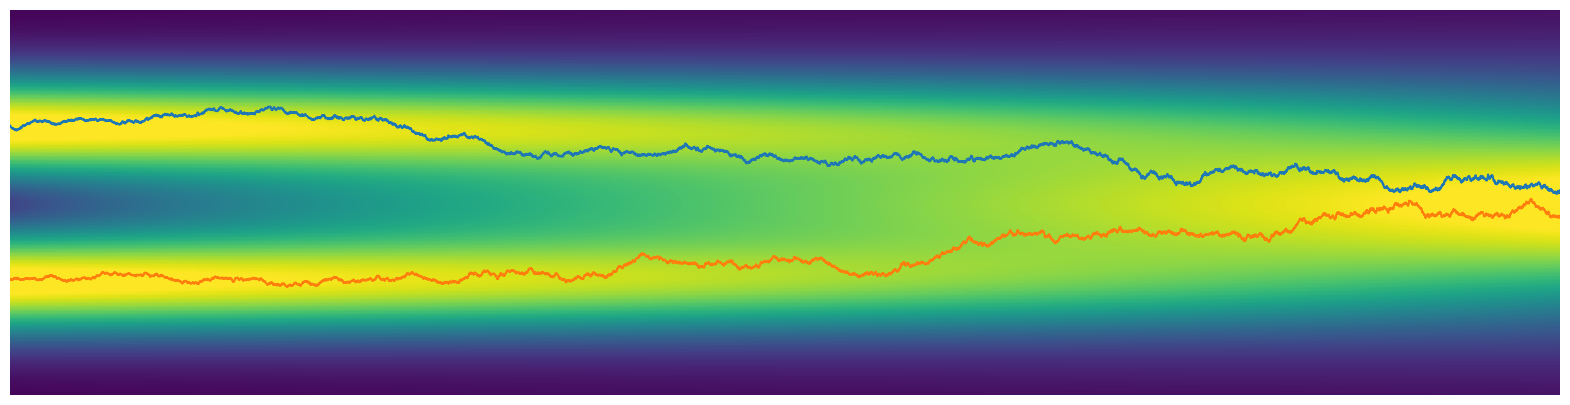

In [4]:
plt.figure(figsize=(20, 5))
plt.imshow(evolution_grid, extent=[0, len(alphas), -5, 5], aspect='auto', cmap='viridis', norm=CustomNorm())
plt.plot(traj_1)
plt.plot(traj_2)
plt.axis('off')
plt.show()

### Diffusion models through the lens of SDEs

To see how diffusion models arise from the framework of SDEs, one has to notice that the SDE defined in Equation (1) directly specifies the direction of time. More specifically, if we assume that the initial distribution is given by $p_0(\mathbf{x})$ and the final distribution by $p_T(\mathbf{x})$, then the SDE from Equation (1) specifies how to transition from $p_0(\mathbf{x})$ to $p_T(\mathbf{x})$ but not from $p_T(\mathbf{x})$ to $p_0(\mathbf{x})$. In generative modelling, where diffusion models excel, one typically wants to approximate a mapping between a complex data distribution $p_{data}$ and some tractable prior distribution $p_{prior}$. Hence, we already see that the mentioned SDE can provide a mapping in only one direction. In addition, this mapping is provided thanks to the coefficients of the SDE, which were easy to find in the example scenario, but are intractable for cases where the target distribution is given by a very complex distribution of e.g. natural images. On the other hand, it is easy to construct an SDE such that a complex distribution transitions to a simple one, e.g. standard gaussian. In conclusion, SDEs provide a very natural way of mapping complex distributions to simple ones. The question is how to obtain the mapping in the reverse direction. 

A key observation made by Song et al. [[1]](#bibliography) is that any SDE possesses its reverse counterpart. If we refer to the SDE defined in Equation (1) as the _forward SDE_, then, following the reasoning by Anderson [[2]](#bibliography), its _reverse SDE_ is given by

\begin{equation}
\frac{d \mathbf{x}(t)}{d t} = [ \mathbf{f}(\mathbf{x}(t), t) - g(t)^2 \nabla_{\mathbf{x}} \log{p_t(\mathbf{x})} ]  + g(t) \frac{d \mathbf{\bar{w}}}{d t}, \tag{2}
\end{equation}

where $\mathbf{\bar{w}}$ is a standard Wiener process with time flowing backwards, $dt$ is an infinitesimal negative timestep, and $\log{p_t(\mathbf{x})}$ is often called the _score_ of the distribution $p_t(\mathbf{x})$. The _reverse_ adjective comes from the fact that the initial and target distributions given by the forward SDE are preserved by following the reverse SDE in the opposite direction of time. Hence, a reverse SDE can provide a mapping from simple distributions to complex ones when its forward counterpart is known. However, an important caveat is that the reverse SDE is typically not available, as it requires access to the score function of the probability distribution at each timestep. This is where diffusion models come into play.

The work of Song et al. [[1]](#bibliography) formulates diffusion models as approximators of the score function in a continuous-time case given by the framework of SDEs. That is, if the parameters of a diffusion model are given as $\boldsymbol{\theta}$, then one aims to obtain

\begin{equation}

\boldsymbol{\theta}^* = \argmin_{\boldsymbol{\theta}}{ \mathbb{E}_t \{ \lambda(t)  \mathbb{E}_{\mathbf{x}(0), \mathbf{x}(t) | \mathbf{x}(0)} [ \lVert \mathbf{s}_{\boldsymbol{\theta}}(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)} \log p_{0t} (\mathbf{x}(t) \mid \mathbf{x}(0) )} \rVert_2^2 ] \}, \tag{3}

\end{equation}

where $\log p_{0t} (\mathbf{x}(t) \mid \mathbf{x}(0))$ denotes the score of the probability distribution of $\mathbf{x}(t)$ given the fact that the initial state is equal to $\mathbf{x}(0)$. This way, diffusion models are trained to approximate the missing component in the reverse SDE and hence allow to map simple distributions to complex ones. As a final note, it is important to emphasize that the score function can be explicitly computed for known data points, which allows to train diffusion models in the first place. What is not available is the score function for the _new, unknown_ data points, which we aim to synthesize using a generative model.

Sampling from a trained diffusion model is performed by first discretizing a given reverse SDE and then inputting the approximated score into its discretized form. Specifically, we can discretize the reverse SDE using the following approximation

\begin{equation}
\frac{d \mathbf{x}(t)}{d t} \approx \frac{\mathbf{x}(t_{i + 1}) - \mathbf{x}(t_{i})}{t_{i + 1} - t_{i}}, \tag{4}
\end{equation}

which, after inserting into Equation (2) and reorganizing the terms, gives the following update rule

\begin{equation}

\mathbf{x}(t_{i+1}) = \mathbf{x}(t_i) + [ \mathbf{f}(\mathbf{x}(t_i), t_i) - g(t_i)^2 \nabla_{\mathbf{x}} \log{p_{t_i}(\mathbf{x})} ] (t_{i+1} - t_i) + g(t_i) \cdot \varepsilon_{t_i}, \tag{5}

\end{equation}

with $\varepsilon_{t_i} \sim \mathcal{N}(\mathbf{0}, (t_{i + 1} - t_i) \mathbf{I})$ and the indices come from a predefined discretization scheme with $t_{i + 1} < t_i$ as the time flows backwards in comparison to the forward SDE. At last, we include the score approximated with the diffusion model into Equation (5), resulting in

\begin{equation}

\mathbf{x}(t_{i+1}) = \mathbf{x}(t_i) + [ \mathbf{f}(\mathbf{x}(t_i), t_i) - g(t_i)^2 s(\mathbf{x}(t_i), t_i) ] (t_{i+1} - t_i) + g(t_i) \cdot \varepsilon_{t_i}. \tag{6}

\end{equation}

### Controllable generation via conditional score

By formulating diffusion models through the framework of SDEs, one also gains additional capabilities of _conditional_ generation, i.e. obtaining samples based on some prior information like class labels or a downsampled version of the desired image.

Denote by $\mathbf{y}$ the condition which we want to include during sampling. In controllable generation, our goal is to sample from $p_0(\mathbf{x}(0) \mid \mathbf{y})$. Importantly, it is easy to show (using Bayes rule and properties of the logarithmic function) that the score function of any time-dependent conditional distribution can be formulated as 

\begin{equation}

\nabla_{\mathbf{x}} \log p_t(\mathbf{x} \mid \mathbf{y}) = \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) + \nabla_{\mathbf{x}} \log p_t(\mathbf{y} \mid \mathbf{x}). \tag{7}

\end{equation}

The reverse SDE can then be adapted with this conditional score as

\begin{equation}
\frac{d \mathbf{x}(t)}{d t} = \{ \mathbf{f}(\mathbf{x}(t), t) - g(t)^2 [ \nabla_{\mathbf{x}} \log p_t(\mathbf{x}) + \nabla_{\mathbf{x}} \log p_t(\mathbf{y} \mid \mathbf{x}) ] \}  + g(t) \frac{d \mathbf{\bar{w}}}{d t}. \tag{8}
\end{equation}

Crucially, this means that controllable generation is possible with the use of diffusion models (in place of $\log p_t(\mathbf{x})$) if the additional score function $ \nabla_{\mathbf{x}} \log p_t(\mathbf{y} \mid \mathbf{x}) $ is also available. For example, if $\mathbf{y}$ is given by class labels, one can train a time-dependent classifier $c_{\boldsymbol{\phi}}(\cdot, t)$ to approximate $p_t(\mathbf{y} \mid \mathbf{x})$ and then obtain an approximation of the conditional score function via $\nabla \log c_{\boldsymbol{\phi}}(\mathbf{x}_t, t)$. Inserting this approximation into Equation (8) together with the output of the diffusion model was shown to be highly effective in various controllable generation tasks [[1]](#bibliography).

### Image inpainting with diffusion models

The problem of image inpainting is generally defined as finding a proper infill of a predefined image region based on the available context. For example, one can pick an arbitrary image of a building such as the one on the left below, specify the masked region as _unknown_ and try to find a plausible infill based on the knowledge contained outside of it. Images 3-8 show possible infills generated by a diffusion model trained on the images of buildings. The inpainted regions are often plausible and semantically correct, meaning that diffusion models are able to encode prior information about the dataset seen during training.

![inpainting_example](inpainting_example.png)

Image inpainting is a special case of conditional generation, where the condition $\mathbf{y}$ is given by the image outside of the masked area. Interestingly, it is possible to utilize the masked region alone to allow for inpainting with the diffusion model, as $p_t(\mathbf{y} | \mathbf{x})$ can be tracked via $ \mathbf{y} = (1 - \mathbf{M}) \odot \mathbf{x}$, where $M$ is a binary mask with $1$ meaning that the region is known and $0$ indicating the area to inpaint. With $\mathbf{y}$ defined this way, $p_t(\mathbf{y} | \mathbf{x})$ can be obtained using e.g. the mean squared error between the image generated at timestep $t$ and the known area:

\begin{equation}
p_t(\mathbf{y} | \mathbf{x}) = 1 - \lVert (1 - \mathbf{M}) \odot (\mathbf{x}_t - \mathbf{x}) \rVert_2^2. \tag{9}
\end{equation}

## Image inpainting with diffusion models in practice

In the following, we include a code snippet extracted from the [score_sde_pytorch](https://github.com/yang-song/score_sde_pytorch?tab=readme-ov-file) GitHub repository (related to Song et al.'s work [[1]](#bibliography)). It allows for:

1. Loading a UNet-based [[3]](#bibliography) diffusion model (termed NCSN++) trained on face images from the CelebA-HQ dataset [[4]](#bibliography).
2. Performing inpainting on a batch of 16 randomly chosen images from the same dataset with masks covering complex parts of the person's face.

The implemented method solves the inpainting problem by following the derivations introduced above. In addition, instead of using the simplest update rule shown in Equation (6), it alternates between the so-called _predictor_ and _corrector_ steps. This approach originates from early research on numerical methods, where each iteration of the SDE solver is decomposed into the prediction of the step and its additional correction. As shown in the paper [[1]](#bibliography), this method can greatly enhance the quality of the obtained results.

In [5]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import numpy as np
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

# import models
from models import utils as mutils
from sde_lib import VESDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector)

def get_data_scaler(config):
  """Data normalizer. Assume data are always in [0, 1]."""
  if config.data.centered:
    # Rescale to [-1, 1]
    return lambda x: x * 2. - 1.
  else:
    return lambda x: x


def get_data_inverse_scaler(config):
  """Inverse data normalizer."""
  if config.data.centered:
    # Rescale [-1, 1] to [0, 1]
    return lambda x: (x + 1.) / 2.
  else:
    return lambda x: x

/raid/shared/bsobieski/conda/envs/diff_inp/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/raid/shared/bsobieski/conda/envs/diff_inp/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [7]:
sde = 'VESDE'

from configs.ve import celebahq_256_ncsnpp_continuous as configs
ckpt_filename = "exp/ve/celebahq_256_ncsnpp_continuous/checkpoint_48.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)

batch_size = 16
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0

sigmas = mutils.get_sigmas(config)
scaler = get_data_scaler(config)
inverse_scaler = get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

/mnt/evafs/faculty/home/bsobieski/diff_inp/utils.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state = torch.load(ckpt_dir, map_location=device)


In [8]:
def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

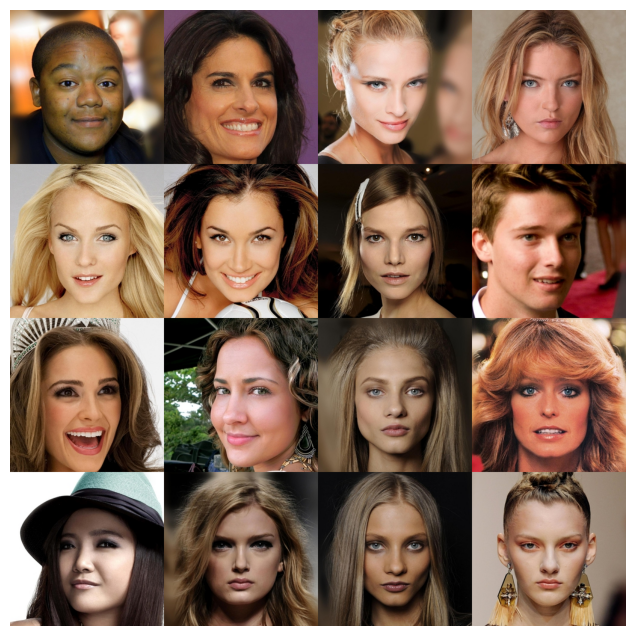

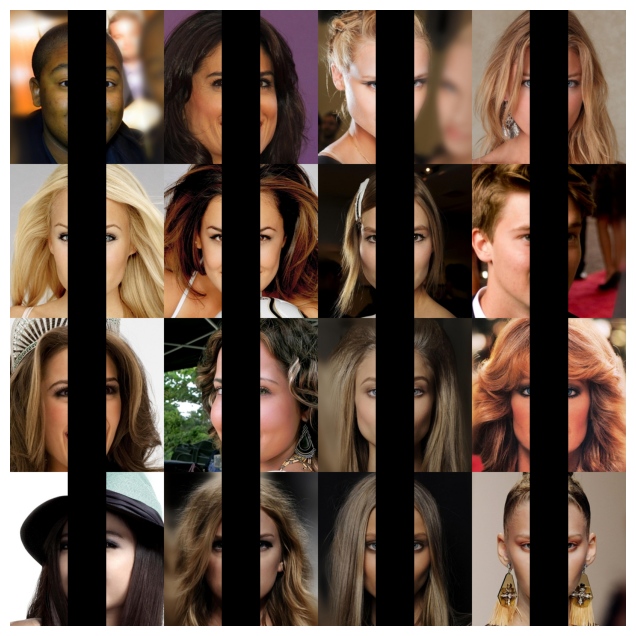

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03817554..1.0337203].


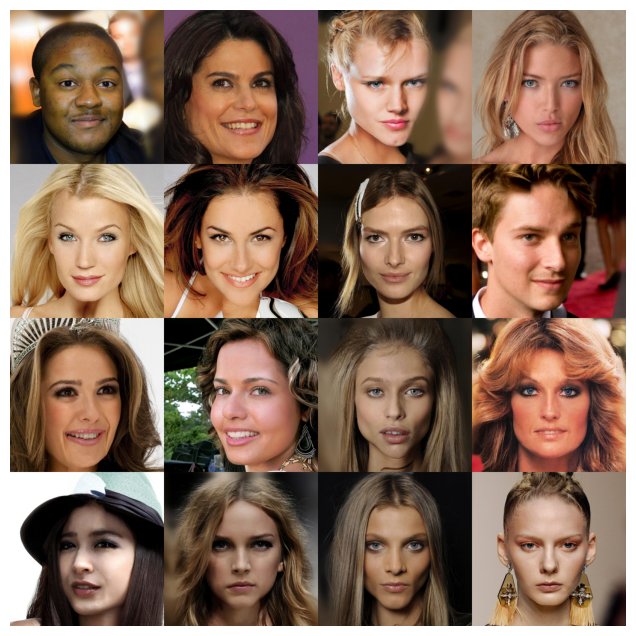

In [9]:
predictor = ReverseDiffusionPredictor
corrector = LangevinCorrector
snr = 0.075
n_steps = 1
probability_flow = False

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)

from pathlib import Path
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
path_data = Path("data") / "celebahq"
imgs = []

for path_img in path_data.rglob("*.png"):
    img = read_image(str(path_img))
    img = convert_image_dtype(img, torch.float32)
    imgs.append(img)

img = torch.stack(imgs).to(config.device)
show_samples(img)

mask = torch.ones_like(img)
mask[:, :, :, 96:160] = 0.
show_samples(img * mask)


x = pc_inpainter(score_model, scaler(img), mask)
show_samples(x)

Despite the fact that the model was given a difficult task of infilling complex parts of the face in each image, we observe that some photos are inpainted in a very realistic way. This approach to the problem of inpainting was one of the first to utilize pretrained diffusion models with no data required to apply them in such scenario. Since then, many more methods emerged with much more accurate infills, thanks to an improved understanding of the theory and practice behind diffusion models [[5](#bibliography), [6](#bibliography), [7](#bibliography)].